# Chapter_4 데이터 분류 모델

## 4.1 타이타닉 생존자 가려내기

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_train = pd.read_csv(r"C:\users\thinp\data\titanic_train.csv")
df_test = pd.read_csv(r"C:\users\thinp\data\titanic_test.csv")

### 4.1.1 탐색: 타이타닉 데이터 살펴보기

In [4]:
df_train.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [6]:
print(df_train.info())
print("------------------------------------------")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
pclass       916 non-null int64
survived     916 non-null int64
name         916 non-null object
sex          916 non-null object
age          741 non-null float64
sibsp        916 non-null int64
parch        916 non-null int64
ticket       916 non-null object
fare         916 non-null float64
cabin        214 non-null object
embarked     914 non-null object
body         85 non-null float64
home.dest    527 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 93.1+ KB
None
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
pclass       393 non-null int64
survived     393 non-null int64
name         393 non-null object
sex          393 non-null object
age          305 non-null float64
sibsp        393 non-null int64
parch        393 non-null int64
ticket       393 non-nul

In [7]:
print(df_train.shape)
print(df_test.shape)

(916, 13)
(393, 13)


In [8]:
# 먼저 name, ticket, body, bome.dest, cabin  피처를 제거합니다..
# 당장 분석에 사용할 수 없거나 큰 의미를 가지고 있지 않은 피처이기 때문입니다.

df_train = df_train.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)
df_test = df_test.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)

0    563
1    353
Name: survived, dtype: int64


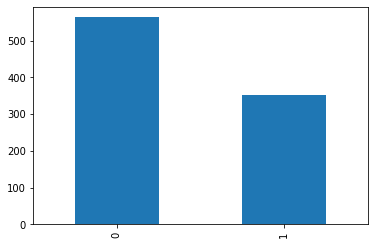

In [11]:
# 시각화를 통해서 EDA를 실시해본다.

print(df_train['survived'].value_counts())
df_train['survived'].value_counts().plot.bar()

3    498
1    230
2    188
Name: pclass, dtype: int64


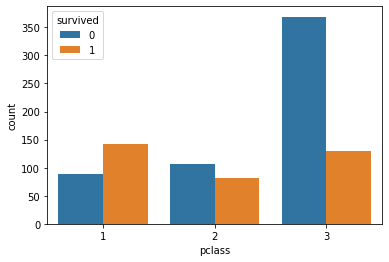

In [12]:
# survived 피처를 기준으로 그룹을 나누어 그룹별 pclass 피처의 분포를 살펴보자.

print(df_train['pclass'].value_counts())
ax = sns.countplot(x = 'pclass', hue = 'survived', data = df_train)

#### 변수 탑색작업 자동화하기

다음은 이러한 피처들을 탐색할 수 있는 자동화 함수 valid_features()를 작성한 것이다. 내용은 다음과 같다.

- 두 그룹 간의 분포를 비교하는 그래프를 출력합니다.
- 두 그룹 각각의 표준편차를 출력합니다.
- 두 그룹 간의 T-test 검정을 실시하여 출력합니다.
- 두 그룹 각각에 Shapiro-wilk 검정을 실시하여 출력합니다.

여기서 Shapiro-wilk 검정이란 주어진 데이터가 얼마나 정규성을 따르는지, 얼마나 정규분포에 가까운지를 측정하는 검정이다.

In [15]:
# 함수를 만들어보자.

from scipy import stats

# 두 집단의 피처를 비교해주며 탐색작업을 자동화하는 함수를 정의합니다.
def valid_features(df, col_name, distribution_check=True):
    
    # 두 집단(survived=1, survived=0) 의 분포 그래프를 출력합니다.
    g  = sns.FacetGrid(df, col='survived')
    g.map(plt.hist, col_name, bins=30)
    
    # 두 집단 (survived=1, survived=0) 의 표준편차를 각각 출력합니다.
    titanic_survived = df[df['survived']==1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    print("data std is", '%.2f' % np.std(titanic_survived_static))
    titanic_n_survived = df[df['survived']==0]
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    print("data std is", '%.2f' % np.std(titanic_n_survived_static))
    
    # T-test로 두 집단의 평균 차이를 검정합니다.
    tTestResult = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name], equal_var=False)
    print("The t-statistic and p-value assuming equal variances is %.3f and %.3f" % tTestResult)
    print("The t-statistic and p-value not assuming equal variances is %.3f and %.3f" % tTestResultDiffVar)
    
    if distribution_check:
        # Shapiro-Wilk 검정: 분포의 정규성 정도를 검증합니다.
        print("The w-statistic and p-value in Survived %.3f and %.3f" %stats.shapiro(titanic_survived[col_name]))
        print("The w-statistic and p-value in Non-Survived %.3f and %.3f" %stats.shapiro(titanic_n_survived[col_name]))

data std is 14.22
data std is 13.71
The t-statistic and p-value assuming equal variances is -0.546 and 0.585
The t-statistic and p-value not assuming equal variances is -0.543 and 0.587
The w-statistic and p-value in Survived 0.982 and 0.001
The w-statistic and p-value in Non-Survived 0.968 and 0.000
data std is 0.64
data std is 1.34
The t-statistic and p-value assuming equal variances is -2.118 and 0.034
The t-statistic and p-value not assuming equal variances is -2.446 and 0.015


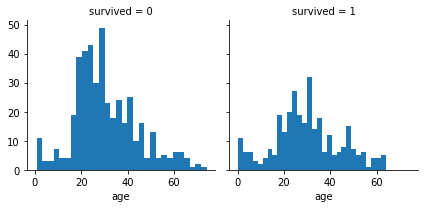

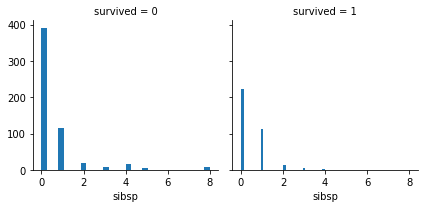

In [16]:
# 앞서 정의한 valid_features 함수를 실행합ㄴ디ㅏ.

valid_features(df_train[df_train['age']> 0], 'age', distribution_check=True)
valid_features(df_train, 'sibsp', distribution_check=False)


### 4.1.2 분류: 생존자 분류 모델 만들기

로지스틱 회귀를 사용해보겠다. 결측값을 먼저 처리해준다.

In [21]:
# 분류 모델을 위해 전처리하기

# age의 결측값을 평균값으로 대체합니다.
replace_mean = df_train[df_train['age'] > 0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

# embark : 2개의 결측값을 최빈값으로 대체합니다.
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

# 원-핫 인코딩을 위한 통합 데이터 프레임을 생성합ㄴ디ㅏ.
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

# pandas 패키지를 이용한 원-핫 인코딩을 수행합ㄴ디ㅏ.
whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

df_train.head(5)

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,1,0,0,0,1
1,2,1,4.000000,1,1,23.0000,1,0,0,0,1
2,2,1,30.000000,1,0,13.8583,1,0,1,0,0
3,3,0,30.231444,0,0,7.7250,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,1,0,0,1,0


In [22]:
# 이제 분류 모델링을 해보자. 로지스틱 회귀 모델을 쓰자.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [23]:
# 데이터를 학습 데이터셋, 테스트 데이터셋으로 분리합ㄴ디ㅏ.

x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

In [24]:
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:, 1]

#### 분류 모델 평가하기

In [26]:
# 테스트 데이터셋에 대한 정확도, 정밀도, 특이도, f1 평가 지표를 각각 출력합니다.

print("accuracy: %.2f" %accuracy_score(y_test, y_pred))
print("Precision: %.3f" %precision_score(y_test, y_pred))
print("Recall: %.3f" %recall_score(y_test, y_pred))
print("F1: %.3f" %f1_score(y_test, y_pred))

accuracy: 0.80
Precision: 0.756
Recall: 0.673
F1: 0.712


In [27]:
# 다음의 코드는 Confusiion Matrix 를 직접 출력한 것이다.

from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[214  32]
 [ 48  99]]


In [28]:
# 마지막으로 로지스틱 회귀 모델의 AUC를 출력해봅니다.

from sklearn.metrics import roc_curve, roc_auc_score

In [31]:
# AUC(Area Under the Curve) 를 계산합니다.

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

AUC : 0.837


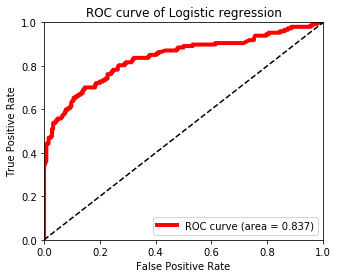

In [32]:
# ROC curve 를 그래프로 출력합니다.

plt.rcParams['figure.figsize'] = [5,4]
plt.plot(false_positive_rate, true_positive_rate, label = 'ROC curve (area = %0.3f)' %roc_auc, color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

In [33]:
# 디시젼 트리 모델로 분류를 해보자.

from sklearn.tree import DecisionTreeClassifier

In [34]:
# 의사결정 나무를 학습하고, 학습한 모델로 테스트 데이터셋에 대한 예측값을 반환합ㄴ디ㅏ.
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
y_pred_probability = dtc.predict_proba(x_test)[:,1]

In [35]:
# 학습한 모델의 성능을 계산하여 출력합니다.

print("accuracy: %.2f" %accuracy_score(y_test, y_pred))
print("Precision: %.3f" %precision_score(y_test, y_pred))
print("Recall: %.3f" %recall_score(y_test, y_pred))
print("F1: %.3f" %f1_score(y_test, y_pred))

accuracy: 0.76
Precision: 0.699
Recall: 0.646
F1: 0.671


In [36]:
# 학습한 모델의 AUC를 계산하여 출력합니다.

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" %roc_auc)

AUC : 0.748


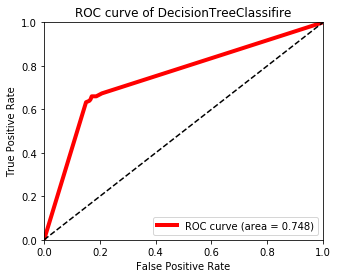

In [37]:
# ROC curve 를 그래프로 출력합니다.

plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label = 'ROC curve (area = %0.3f)' %roc_auc, color='red', linewidth=4.0)
plt.plot([0, 1],[0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve of DecisionTreeClassifire")
plt.legend(loc = "lower right")

### 4.1.3 모델 개선 : 피처 엔지니어링 첫걸음

#### 분류 모델을 위해 전처리하기

In [38]:
# 데이터를 다시 불러옵니다.

train = pd.read_csv(r"C:\users\thinp\data\titanic_train.csv")
test = pd.read_csv(r"C:\users\thinp\data\titanic_test.csv")
train = train.drop(['ticket', 'body', 'home.dest'], axis=1)
test = test.drop(['ticket', 'body', 'home.dest'], axis=1)

In [40]:
# age의 결측값을 평균값으로 대체하고

replace_mean = train[train['age']> 0]['age'].mean()
train['age'] = train['age'].fillna(replace_mean)
test['age'] = test['age'].fillna(replace_mean)

In [41]:
# embark : 2개의 결측값을 최빈값으로 대체합니다.

embarked_mode = train['embarked'].value_counts().index[0]
train['embarked'] = train['embarked'].fillna(embarked_mode)
test['embarked'] = test['embarked'].fillna(embarked_mode)

In [42]:
# 원핫 인코딩을 위한 통합 데이터 프레임을 생성

whole_df = train.append(test)
train_idx_num = len(train)

#### Cabin 피처를 사용하자

In [43]:
print(whole_df['cabin'].value_counts()[:10])

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
F4                 4
F2                 4
B96 B98            4
D                  4
C78                4
F33                4
Name: cabin, dtype: int64


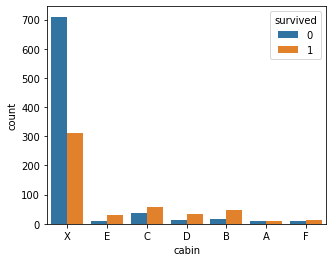

In [44]:
# cabin 정리를 해보자.

# 결측값은 X로 넣는다.
whole_df['cabin'] = whole_df['cabin'].fillna('X')

# cabin 피처의 첫 번째 알파벳을 추출한다.
whole_df['cabin'] = whole_df['cabin'].apply(lambda x: x[0])

# 추출한 알파벳 중, ,G와 T는 수가 너무 작기 때문에 마찬가지로 X로 대체한다.
whole_df['cabin'] = whole_df['cabin'].replace({'G':'X', 'T':'X'})

ax = sns.countplot(x = 'cabin', hue='survived', data= whole_df)
plt.show()

#### name 피처 사용하기

In [45]:
# 이름에서 호칭을 추출합니다.

name_grade = whole_df['name'].apply(lambda x : x.split(", ",1)[1].split(".")[0])
name_grade = name_grade.unique().tolist()
print(name_grade)

['Miss', 'Mr', 'Master', 'Mrs', 'Dr', 'Mlle', 'Col', 'Rev', 'Ms', 'Mme', 'Sir', 'the Countess', 'Dona', 'Jonkheer', 'Lady', 'Major', 'Don', 'Capt']


In [46]:
# 호칭에 따라 사회적 지위(1910년대를 기준)를 정의합니다.
grade_dict = {'A' : ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir'], # 명예직을 나타냅니다.
             'B' : ['Ms', 'Mme', 'Mrs', 'Dona'], # 여성을 나타냅니다.
             'C' : ['Jonkheer', 'the Countess'], # 귀족이나 작위를 나타냅니다.
             'D' : ['Mr', 'Don'], # 남성을 나타냅니다.
             'E' : ['Master'], # 젊은 남성을 나타냅니다.
             'F' : ['Miss', 'Mlle', 'Lady']} # 젊은 여성을 나타냅니다.

In [52]:
# 정의한 호칭의 기준에 따라 A-F의 문자로 name 피처를 다시 정의하는 함수입니다.
def give_grade(x):
    grade = x.split(", ", 1)[1].split(".")[0]
    for key, value in grade_dict.items():
        for title in value:
            if grade == title:
                return key
    return 'G'

In [53]:
# 위의 함수를 적용하여 name 피처를 새롭게 정의합니다.

whole_df['name'] = whole_df['name'].apply(lambda x: give_grade(x))
print(whole_df['name'].value_counts())

D    758
F    263
B    201
E     61
A     24
C      2
Name: name, dtype: int64


      survived
name          
A     0.333333
B     0.786070
C     0.500000
D     0.162269
E     0.508197
F     0.680608


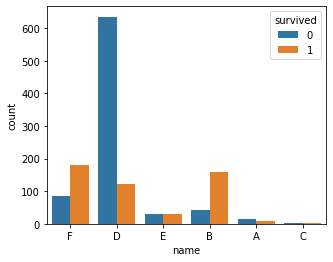

In [55]:
# 시각화하여 살펴봅니다.

ax = sns.countplot(x = 'name', hue='survived', data=whole_df)
print(pd.pivot_table(whole_df, index ='name', values='survived'))

In [56]:
# 모델을 학습시키기 위해 원핫 인코딩을 하겠습니다.

whole_df_encoded = pd.get_dummies(whole_df)
train = whole_df_encoded[:train_idx_num]
test = whole_df_encoded[train_idx_num:]
train.head(5)

,pclass,survived,age,sibsp,parch,fare,name_A,name_B,name_C,name_D,...,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_X,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,4.000000,1,1,23.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2,1,30.000000,1,0,13.8583,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,3,0,30.231444,0,0,7.7250,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


accuracy: 0.80
Precision: 0.758
Recall: 0.680
F1: 0.717
AUC : 0.851


C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


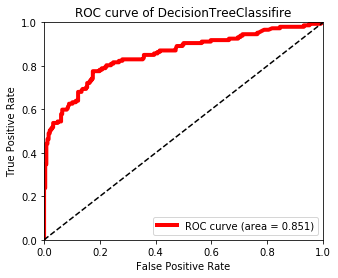

In [57]:
# 데이터를 학습 데이터셋, 테스트 데이터셋으로 분리합ㄴ디ㅏ.

x_train, y_train = train.loc[:, df_train.columns != 'survived'].values, train['survived'].values
x_test, y_test = test.loc[:, df_test.columns != 'survived'].values, test['survived'].values

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:, 1]

# 학습한 모델의 성능을 계산하여 출력합니다.

print("accuracy: %.2f" %accuracy_score(y_test, y_pred))
print("Precision: %.3f" %precision_score(y_test, y_pred))
print("Recall: %.3f" %recall_score(y_test, y_pred))
print("F1: %.3f" %f1_score(y_test, y_pred))

# 학습한 모델의 AUC를 계산하여 출력합니다.

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" %roc_auc)

# ROC curve 를 그래프로 출력합니다.

plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label = 'ROC curve (area = %0.3f)' %roc_auc, color='red', linewidth=4.0)
plt.plot([0, 1],[0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve of DecisionTreeClassifire")
plt.legend(loc = "lower right")

#### 피처 영향력 살펴보기

ValueError: shape mismatch: objects cannot be broadcast to a single shape

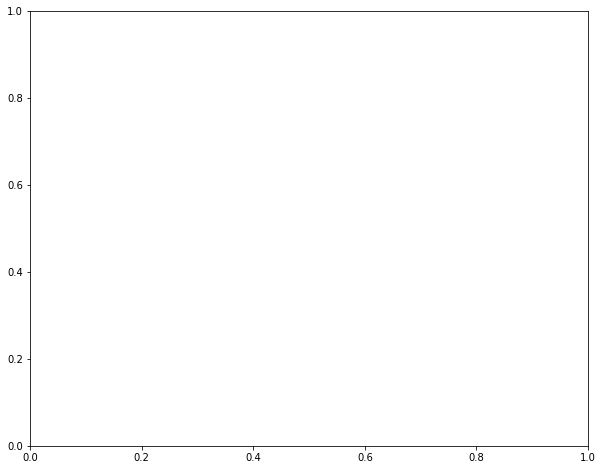

In [67]:
# 예측 대상인 survived 피처를 제외한 모든 피처를 리스트로 반환합니다.

cols = train.columns.tolist()
cols.remove('survived')
y_pos = np.arange(len(cols))

# 각 피처별 회귀 분석 계수를 그래프의 X축으로 하여 피처 영향력 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [10, 8]
fig, ax = plt.subplots()
ax.barh(y_pos, lr.coef_[0], align = 'center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()
ax.set_xlabel('Coef')
ax.set_title("Each Feature's Coef")

plt.show()

### 4.1.4 평가 : 모델 검증하기

#### k-fold 교차 검증 수행하기

In [68]:
from sklearn.model_selection import KFold

C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

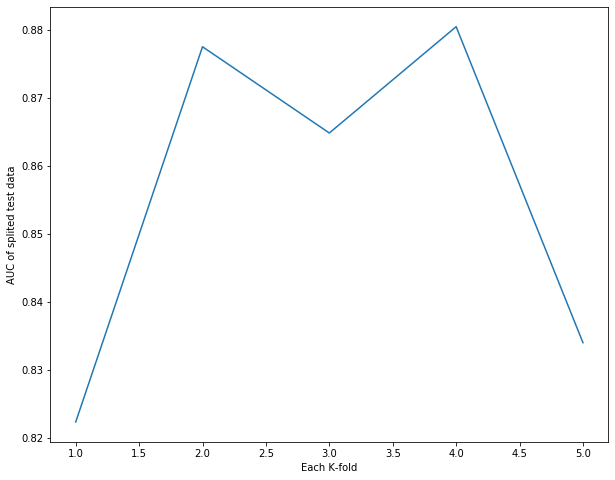

In [71]:
# k-fold 교차 검증의 k를 5로 설정합니다.
k = 5
cv = KFold(k, shuffle=True, random_state=0)
auc_history = []

# k-fold를 5번의 분할 학습으로 반복합니다.
for i, (train_data_row, test_data_row) in enumerate(cv.split(whole_df_encoded)):
    
    # 5개로 분할된 fold 중 4개를 학습 데이터셋, 1개를 테스트 데이터셋으로 지정합니다. 매 반복시 변경됩니다.
    train = whole_df_encoded.iloc[train_data_row]
    test = whole_df_encoded.iloc[test_data_row]
    
    # survived 피처를 y, 나머지 피처들을 x 데이터로 지정합니다.
    splited_x_train, splited_y_train = train.loc[:, train.columns != 'survived'].values, train['survived'].values
    splited_x_test, splited_y_test = test.loc[:, test.columns != 'survived'].values, test['survived'].values
    
    # 주어진 데이터로 로지스틱 회귀 모델을 학습합니다.
    lr = LogisticRegression(random_state=0)
    lr.fit(splited_x_train, splited_y_train)
    y_pred = lr.predict(splited_x_test)
    y_pred_probability = lr.predict_proba(splited_x_test)[:, 1]
    
    # 테스트 데이터셋의 AUC를 계산하여 auc_history에 저장합니다.
    false_positive_rate, true_positive_rate, thresholds = roc_curve(splited_y_test, y_pred_probability)
    roc_auc = roc_auc_score(splited_y_test, y_pred_probability)
    auc_history.append(roc_auc)
    
# auc_history  에 저장된 다섯번의 학습 결과(AUC) 를 그래프로 출력합니다.
plt.xlabel("Each K-fold")
plt.ylabel("AUC of splited test data")
plt.plot(range(1, k+1), auc_history) #baseline

In [72]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [73]:
# 학습 곡선 분석하기

import scikitplot as skplt

C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default s

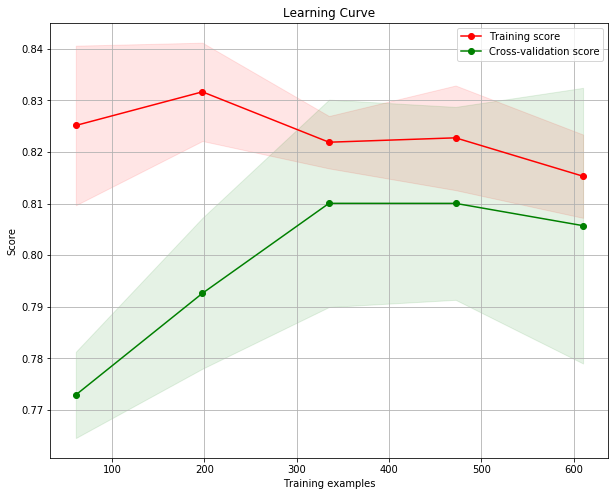

In [74]:
skplt.estimators.plot_learning_curve(lr, x_train, y_train)
plt.show()

## 4.2 강남역 맛집 리뷰로 알아보는 감성 분류

### 4.2.1 크롤링: 네이버 플레이스 리뷰 크롤링

네이버 플레이스의 강남역 고기집 관련도순 상위 100개의 고기집을 긁어오려고 한다.

아래의 코드와 같이 검색 규칙 파라미터를 주면 된다.

- start, display : 검색 결과를 얼마만큼 보여줄지에 관련된 파라미터
- query : 검색하고 싶은 장소나 음식점에 대한 검색어
- sortingOrder : 어떤 방식으로 검색 결과를 정렬할지에 대한 파라미터

검색 규칙을 추가한 url_concat 에 requests.get 함수를 적용하면 json 형태의 검색 결과 데이터를 얻는다.

이를 다시 json.loads 함수로 변환하면 파이썬의 dictionary 와 동일한 형태로 사용 가능하다.

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json

#### 관련도순 상위 100개의 고기집 리스트 정보 API 구하기

In [7]:
# 네이버 플레이스 API를 호출하기 위한 기본 주소
source_url = "https://store.naver.com/sogum/api/businesses?"

In [8]:
# 검색 규칙 파라미터를 추가합니다.
url_parameter_start = "start=1"
url_parameter_display = "&display="
url_parameter_query = "&query=강남역+고기집"
url_parameter_sorting = "&sortingOrder=precision"
url_concat = source_url + url_parameter_start + url_parameter_display + str(100)+ url_parameter_query + url_parameter_sorting

In [9]:
# 반화낟은 API 데이터에 json.loads 함수를 사용합니다.
json_data = requests.get(url_concat).text
restaurant_list_data = json.loads(json_data)

In [10]:
# 관련도순 상위 100개의 고기집 리스트를 출력합니다.
print(str(restaurant_list_data)[:100]+"...")

{'query': {'select': '1', 'item': [{'rank': '1', 'region_keyword': '강남역', 'region_type': 'favor', 'r...


하지만 크롤링으로 가져온 데이터에는 리뷰 데이터가 아직 없다. 이를 얻기 위해서는 랭킹 목록의 상세 페이지로 이동해야 한다.

각 상세 페이지는 "https://store.naver.com/restaurant/detail?id=" 의 URL 형태이며 이 형식에 들어갈 id  정보를 추출해야 한다.

#### 크롤링에 필요한 id 정보 추출하기

In [11]:
# 크롤링에 필요한 id 정보를 추출하자.

restaurant_id_list = []

In [12]:
# 100개씩의 API 호출 결과를 3회 가져옵니다.
for start_idx in [1, 101, 201]:
    
    #네이버 플레이스 API를 호출하기 위한 기본 주소
    source_url = "https://store.naver.com/sogum/api/businesses?"
    
    #검색 규칙 파라미터 추가
    url_parameter_start = "start=" + str(start_idx)
    url_parameter_display = "&display="
    url_parameter_query = "&query=강남역+고기집"
    url_parameter_sorting = "&sortingOrder=precision"
    url_concat = source_url + url_parameter_start + url_parameter_display + str(start_idx +99) \
    + url_parameter_query + url_parameter_sorting
    
    json_data = requests.get(url_concat).text
    restaurant_list_data = json.loads(json_data)
    
    # 크롤링에 필요한 각 리뷰 상세 페이지의 id를 추출합니다.
    for restaurant in restaurant_list_data['items']:
        if 'moreBookingReviewsPath' in restaurant:
            restaurant_id_list.append(restaurant['id'])
            
restaurant_id_list = list(set(restaurant_id_list))

start 파라미터를 301 이상으로 주면 오류가 뜬다. 이유는 모르겠지만. 그래서 300까지만 추출했다.

다음으로는 추출한 id 를 이용해서 각 페이지에서 리뷰 데이터와 평점 데이터를 크롤링 하자.

#### 가져온 맛집 리스트의 리뷰 정보 크롤링하기

In [13]:
import requests
from bs4 import BeautifulSoup
import re

In [14]:
columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

In [15]:
# 리뷰 상세 페이지의 기본 주소
source_url_head = "https://store.naver.com/restaurants/detail?id="
source_url_tail = "&tab=bookingReview#_tab"

In [16]:
for idx in range(0, len(restaurant_id_list)):
    
    # 앞서 추출한 리뷰 상세 페이지의 id를 기본 주소의 파리미터로 추가합니다.
    req = requests.get(source_url_head +  str(restaurant_id_list[idx]) + source_url_tail)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    review_area = soup.find(name="div", attrs={"class":"review_area"})
    
    # 리뷰가 없는 페이지는 아무 작업도 수행하지 않습니다.
    if review_area is None:
        continue
        
    # 개발자 도구로 살펴본 html 구조에서 리뷰의 점수, 텍스트 부분을 추출합니다.
    review_list = review_area.find_all(name = "div", attrs = {"class":"info_area"})
    for review in review_list:
        score = review.find(name="span", attrs = {"class":"score"}).text
        review_txt = review.find(name="div", attrs = {"class":"review_txt"}).text
        
        # 추출한 리뷰의 점수, 리뷰 텍스트를 데이터 프레임으로 병합
        row = [score, review_txt]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)

In [17]:
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰로 평가합니다.
df['y'] = df['score'].apply(lambda x: 1 if int(x) > 3 else 0)
print(df.shape)
df.head()

(836, 3)


,score,review,y
0,5,차돌삼합 먹었는데 너무맛있었네용!!\n볶음밥까지 굿굿👍👍,1
1,5,넘넘 맛있어요!,1
2,4,양은 좀 적었는데 맛은 엄청있음,1
3,5,3번째 방문이고 역시 맛있었고\n데리고간 친구들 모두 만족하고 맛있게 먹음!\n또 ...,1
4,5,직원들의 친절한 응대에 감사를 드리며 음식점에서 가장 중요한것은 역시 맛인데 삼합의...,1


### 4.2.2 텍스트 전처리: 분류 모델 피처로 변환하기

In [15]:
#pip install konlpy

In [16]:
#pip install jpype1

In [17]:
#pip install jpype1-py3

#### 한글 텍스트로 전처리하기

In [18]:
# 텍스트 정제 함수: 한글 이외의 문자는 전부 제거합니다.
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출합니다.
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [19]:
# 함수를 적용하여 리뷰에서 한글만 추출합니다.
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']
df.head()

,score,y,ko_text
0,5,1,차돌삼합 먹었는데 너무맛있었네용볶음밥까지 굿굿
1,5,1,넘넘 맛있어요
2,4,1,양은 좀 적었는데 맛은 엄청있음
3,5,1,번째 방문이고 역시 맛있었고데리고간 친구들 모두 만족하고 맛있게 먹음또 새로운 친구...
4,5,1,직원들의 친절한 응대에 감사를 드리며 음식점에서 가장 중요한것은 역시 맛인데 삼합의...


#### 형태소 단위의 추출 함수 정의하기

In [20]:
from konlpy.tag import Okt

In [21]:
# konlpy 라이브러리로 텍스트 데이터에서 형태소를 추출합니다.

def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word, tag) for word,tag in pos]
    return pos

In [22]:
# 형태소 추출 동작을 테스트합니다.
result = get_pos(df['ko_text'][0])
print(result)    

['차돌/Noun', '삼/Modifier', '합/Noun', '먹었는데/Verb', '너무/Adverb', '맛있었/Adjective', '네/Determiner', '용/Noun', '볶음밥/Noun', '까지/Josa', '굿굿/Noun']


이제 텍스트 데이터의 마지막 전처리 과정이다. 이번 단계의 핵심은 텍스트를 분류 모델에 학습이 가능한 데이터셋으로 만드는 것이다.

텍스트 데이터를 연산 가능한 피처로 만드는 방법은 다음과 같다.

- 1. raw 데이터셋 : 데이터 프레임의 텍스트 데이터에 해당합니다.
- 2. 말뭉치 : raw 데이터셋으로부터 말뭉치를 생성합니다. 이 말뭉치는 형태소의 서로 다른 고유한 셋을 가지고 있습니다.
- 3. 학습 데이터셋: 서로 다른 6개의 형태소는 각 텍스트 데이터의 벡터 길이가 됩니다. 만약 텍스트에 해당 단어가 존재하면 벡터를 1로.

#### 분류 모델의 학습 데이터로 변환하기: corpus index 생성

In [23]:
# 사이킷런의 카운트벡터라이저로 위 작업을 실행한다.
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.

index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
x = index_vectorizer.fit_transform(df['ko_text'].tolist())
print(x.shape)

(836, 3465)


In [26]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'차돌/Noun': 2921, '삼/Modifier': 1635, '합/Noun': 3321, '먹었는데/Verb': 1206, '너무/Adverb': 585, '맛있었/Adje..


In [28]:
print(df['ko_text'][0])
print(x[0])

차돌삼합 먹었는데 너무맛있었네용볶음밥까지 굿굿
  (0, 349)	1
  (0, 447)	1
  (0, 1467)	1
  (0, 2312)	1
  (0, 602)	1
  (0, 1121)	1
  (0, 585)	1
  (0, 1206)	1
  (0, 3321)	1
  (0, 1635)	1
  (0, 2921)	1


#### 분류 모델의 학습 데이터로 변환하기: TF-IDF로 변환

TF-IDF는 단어 빈도를 나타내는 TF와 문서 빈도를 나타내는 DF의 역수인 IDF를 곱한 값을 의미한다. 암튼 빈도에 대한 조정을 준다.

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer

In [32]:
# TF-IDF 방법으로 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.

tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(x)

In [33]:
print(X.shape)
print(X[0])

(836, 3465)
  (0, 3321)	0.27588448060235743
  (0, 2921)	0.2857919003750231
  (0, 2312)	0.3128883000714231
  (0, 1635)	0.2674325749437588
  (0, 1467)	0.27900153533736916
  (0, 1206)	0.29776261479220106
  (0, 1121)	0.382299100966653
  (0, 602)	0.382299100966653
  (0, 585)	0.1567652276501738
  (0, 447)	0.2359235273581747
  (0, 349)	0.36571380686338856


### 4.2.3 분류: 긍정/부정 리뷰 분류하기

#### 분류 모델링: 데이터셋 분리

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(585, 3465)
(251, 3465)


#### 분류 모델링: 로지스틱 회귀 모델

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [37]:
# 로지스틱 회귀 모델을 학습합ㄴ디ㅏ.

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [38]:
# 로지스틱 회귀 모델의 성능을 평가합니다.

print("accuracy: %.2f" %accuracy_score(y_test, y_pred))
print("Precision: %.2f" %precision_score(y_test, y_pred))
print("Recall: %.2f" %recall_score(y_test, y_pred))
print("F1: %.2f" %f1_score(y_test, y_pred))


accuracy: 0.92
Precision: 0.92
Recall: 1.00
F1: 0.96


In [39]:
# 평가 수치가 너무 높아서 의심스럽기 떄문에 Confusion Matrix를 실행해봅니다.

from sklearn.metrics import confusion_matrix

In [40]:
# Confusion Matrix 를 출력합니다.

confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[  0  20]
 [  0 231]]


In [41]:
# 위의 결과를 보면 모든 결과를 1로 예측한다. 클래스의 불균형 문제가 생겼다.
# 적절한 샘플링 방법을 통해 클래스의 불균형 문제를 해결해야 한다.

# Y가 0과 1을 얼마나 가지고 있는지를 출력합니다.
df['y'].value_counts()

1    777
0     59
Name: y, dtype: int64

#### 클래스 불균형 문제 해결하기: 1:1 비율의 랜덤 샘플링

In [42]:
# 1:1 비율로 랜덤 샘플링을 수행합니다.

positive_random_idx = df[df['y'] ==1].sample(50, random_state=30).index.tolist()
negative_random_idx = df[df['y'] ==0].sample(50, random_state=30).index.tolist()


In [43]:
# 랜덤 데이터로 데이터셋을 나눕니다.
random_idx = positive_random_idx + negative_random_idx
sample_X = X[random_idx, :]
y = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(sample_X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(70, 3465)
(30, 3465)


In [44]:
# 자 로지스틱 회귀 모델을 다시 학습하자.

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [45]:
print("accuracy: %.2f" %accuracy_score(y_test, y_pred))
print("Precision: %.2f" %precision_score(y_test, y_pred))
print("Recall: %.2f" %recall_score(y_test, y_pred))
print("F1: %.2f" %f1_score(y_test, y_pred))


accuracy: 0.47
Precision: 0.43
Recall: 1.00
F1: 0.60


In [46]:
# Confusion Matrix 를 출력합니다.

confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[ 2 16]
 [ 0 12]]


### 4.2.4 분석: 중요 키워드 분석하기

#### 회귀 모델의 피처 영향력 추출하기

[(0.48008098790992493, 1119), (0.4066484745667643, 1171), (0.39115782228939333, 2854), (0.38248786378204147, 897), (0.3728258639298296, 114)]
[(-0.31685913602305027, 2387), (-0.34408482962207554, 2373), (-0.37692268203428714, 2368), (-0.42868391027457486, 1541), (-0.5307030736863471, 1459)]


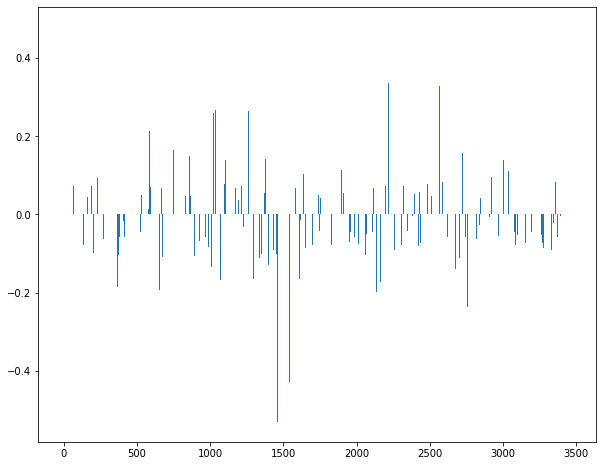

In [47]:
# 학습한 회귀 모델의 계수를 출력합니다.
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

#### 중요 변수의 형태소

In [49]:
# 회귀 모델의 계수를 높은 순으로 정렬합니다.
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

# 회귀 모델의 계수를 index_vectorizer에 맵핑하여 어떤 형태소인지 출력할 수 있게 합니다.
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로 피처에 형태소를 맵핑한 결과를 출력한다. 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있다.
print(str(invert_index_vectorizer)[:100]+'..')

{2921: '차돌/Noun', 1635: '삼/Modifier', 3321: '합/Noun', 1206: '먹었는데/Verb', 585: '너무/Adverb', 1121: '맛있..


#### 상위 20개 긍정 형태소 출력하기

In [50]:
# 상위 20개 긍정 형태소를 출력합니다.

for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

맛있어요/Adjective 0.48008098790992493
먹고/Verb 0.4066484745667643
진짜/Noun 0.39115782228939333
들/Suffix 0.38248786378204147
감사합니다/Verb 0.3728258639298296
깔끔하고/Adjective 0.34965597549712885
맛있게/Adjective 0.34265832625613185
예약/Noun 0.3361380773552593
돼지/Noun 0.33245001714981487
마다/Josa 0.33114329149928234
잘/Verb 0.3292245668571377
완전/Noun 0.31266481321830303
맛있습니다/Adjective 0.312380262291264
갑니다/Verb 0.31003404992969513
도/Josa 0.2806211754025378
늘/Noun 0.27440942132794055
만족하며/Adjective 0.266997284341967
만족했습니다/Adjective 0.2643970544338404
모두/Noun 0.26378970754410913
갈/Verb 0.2621198984668022
